## Features:

### Client:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0


### Invoice data

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter


## Some findings

- the "test" = "competition" set (no targets there). Therefore must split the "train" set into train/test sets

- must not aggregate to make a shorter table with customers. Instead predict on TRANSACTIONS. (df.groupby('client_id').nunique())

- the proportion of positives is higher in the merged "transactions" table than the proportion of positives in the "clients" table (0.06 / 0.08).  So you can treat that as "perturbation" of positives in order to increase the number of positives (where they are scarse). I.e. this is one more argument in the favour of predicting on transactions  and then aggregating them to get a prediction for a particular customer.

- the 'months_number' column does not contain actual months. These values do not correspond to the 'creation_date' or 'invoice_date' columns.  Either keep this columns without any transformation or scaling or delete it completeley. Because the test set contains this kidn of wierd values too.

- the features  ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']   are not very promising (in tearms of building univariate logistic regression on them)

- columns 'counter_statue'  is supposed to be integers [0-5] but is of mixed type (object) with some bogus values.  Convert to int, drop the rows with values > 5, because the test set doesnt have any bad values in this column - only the valid integers from 0 to 5

- search for a decent baseline model didn't give decent results. Try non-deterministic baseline model based on the prior (i.e. the proportion of positives in the population)

- eventually agreed to predict transactions (and not fraudulent clients)

- rule-based baseline model on two rules (2005, higher consumption)


In [10]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import fbeta_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from sklearn.linear_model import LogisticRegression

In [ ]:
# TODO: random seed
...

In [12]:
# feature preprocessing functions

def preprocess(feature, data):
    functions = {'counter_statue': preprocess_counter_statue}
    feature = feature if type(feature) is str else data.name if type(data) is pd.Series else data.columns[feature]
    function = functions[feature]
    return function(data)

    
# preprocess 'counter_statue'
def preprocess_counter_statue(data):
    col = 'counter_statue'
    sr = data[col].astype(str)
    mask = sr.isin(list("012345"))
    sr[~mask] = sr[mask].mode().values[0]
    data[col] = sr.astype(int)


In [13]:
path1 = "data/train/client_train.csv"
path2 = "data/train/invoice_train.csv"

path3 = "data/test/client_test.csv"
path4 = "data/test/invoice_test.csv"

In [14]:
# load the data

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)     # low_memory=False

df3 = pd.read_csv(path3)
df4 = pd.read_csv(path4)

/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_94549/4049219884.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(path2)     # low_memory=False


In [15]:
# join tables

# data from the "train" folder (will have to be split into train/test)
df_entire = df1.merge(df2, left_on='client_id', right_on='client_id', how='outer')

# data from the "test" folder (doesn't contain targets)
df_test_zindi = df3.merge(df4, left_on='client_id', right_on='client_id', how='outer')


In [16]:
# converts all values to int, fills bad values with the mode
preprocess('counter_statue', df_entire)

In [17]:
# quick feature engineering 

df_entire['year_created'] = pd.to_datetime(df_entire['creation_date']).dt.year
dates = pd.to_datetime(df_entire['invoice_date'])
df_entire['invoice_year'] = dates.dt.year
df_entire['invoice_month'] = dates.dt.month
df_entire['invoice_weekday'] = dates.dt.weekday

/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_94549/1867216858.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_entire['year_created'] = pd.to_datetime(df_entire['creation_date']).dt.year


In [18]:
# drop the observations before 2005

YEAR = 2005
df_entire.drop(df_entire.index[df_entire['invoice_year'] < YEAR], axis=0, inplace=True)

In [19]:
# enlabel 'counter_type'

df_entire['counter_type'], _ = pd.factorize(df_entire['counter_type'])

In [20]:
# drop these columns

cols = ['disrict', 'client_id', 'creation_date', 'invoice_date', 'old_index']
df_entire.drop(cols, axis=1, inplace=True)

In [21]:
# rearrange the columns, so that the target is the last (optional)
...

In [22]:
# feature engineering: interaction between the 4 features
# takes a long time     # if product=0 then target=0 ?  experiment with this
"""
df_entire['mult'] = df_entire[['consommation_level_1', 'consommation_level_2',
                 'consommation_level_3', 'consommation_level_4']].apply(np.multiply.reduce, axis=1)
"""

"\ndf_entire['mult'] = df_entire[['consommation_level_1', 'consommation_level_2',\n                 'consommation_level_3', 'consommation_level_4']].apply(np.multiply.reduce, axis=1)\n"

In [23]:
# split the data

# make random indeces/mask
m = len(df_entire)
p = .80   # for the train set
nx = np.random.permutation(m)[:int(m*p)]
mask = np.zeros(m).astype(bool)
mask[nx] = True

# split
df_train = df_entire[mask]
df_test = df_entire[~mask]


#### a quick reminder:
df_test_zindi = the test set from the "test" folder (no targets there)

df_entire = the entire dataset from the "train" folder (from which we dropped cases before 2005)

df_train = train subset from df_entire

df_test = test subset from df_entire

df = temporary random subset of df_train (for experemintation purposes)

## Feature Selection

### features to use:

* client_catg
* region
* tarif_type

* counter_number 
* counter_statue
* counter_code
* reading_remarqu
* counter_coefficient

* consommation_level_1 ... consommation_level_4 (baseline model)
* new_index - ?
* months_number
* counter_type


### features to omit:

* disrict (this information is dependent on 'region' and is "stored" there already)
* client_id
* creation_date
* invoice_date (feature engineer month / year?)
* old_index (almost perfectly correlates with 'new_index')


### features to engineer:

* month
* year
* ratios

## Feature engineering
#### (average consumption by year and month)



In [43]:
# sample for experements and development   ! df is overwritten
df = df_train.sample(500_000)

##### note: df is a random subset from df_train 
can do: df = df_train  to run the following code on the whole df_train,
or change the name 'df' to 'df_train' / 'df_test'. in the following code

In [44]:
cols = ['consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'invoice_year', 'invoice_month']

df_lookup = df[cols].groupby(by=['invoice_year', 'invoice_month']).mean()

In [45]:
df_lookup.head(15)

consommation_level_1  consommation_level_2  \
invoice_year invoice_month                                               
2005         1                        372.187266             58.333333   
             2                        409.590909            284.153409   
             3                        384.067568             67.108108   
             4                        535.055944             93.181818   
             5                        451.835443            117.793249   
             6                        446.474638            144.170290   
             7                        389.656716             94.202559   
             8                        357.422096             90.966006   
             9                        436.420660            382.987220   
             10                       381.766428             65.817176   
             11                       395.601744            112.819767   
             12                       369.584689            121.736842   
2006         1                        434.188546            141.852423   
             2                        449.565703            200.951801   
             3                        406.970417            138.478177   

                            consommation_level_3  consommation_level_4  
invoice_year invoice_month                                              
2005         1                          0.000000                   0.0  
             2                          0.000000                   0.0  
             3                          0.000000                   0.0  
             4                          0.000000                   0.0  
             5                          0.000000                   0.0  
             6                          0.000000                   0.0  
             7                          0.000000                   0.0  
             8                          0.000000                   0.0  
             9                          0.000000                   0.0  
             10                         0.000000                   0.0  
             11                         0.000000                   0.0  
             12                         0.000000                   0.0  
2006         1                          0.000000                   0.0  
             2                          1.309995                   0.0  
             3                          1.577595                   0.0

In [46]:
# time the operations
import time

In [47]:
def lookup(sr, **kwargs):
    # ! cannot handle non Series
    # TODO if (2004, 12) not found - return what? - overall average for that month?
    # try: error
    sr = df_lookup.loc[tuple(sr)]
    return sr


# if this is the train df then:
t0 = time.perf_counter()
nx = list(zip(df['invoice_year'], df['invoice_month']))
df_avg_consumption = df_lookup.loc[nx].reset_index(drop=True)
print("super indexing time:", time.perf_counter() - t0)

""" commented this out because takes a long time - but will need this in the prediction/setting
# if df_test (or new data) then use the lookup function 
t0 = time.perf_counter()
df_avg_consumption = df[['invoice_year', 'invoice_month']].apply(lookup, axis=1)
print("apply lookup time:", time.perf_counter() - t0)
"""

df_avg_consumption.head(4)


super indexing time: 0.4784177500000055


,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
0,422.452150,302.078595,0.00000,0.000000
1,408.002848,149.220218,0.00000,0.000000
2,428.539650,160.084994,0.00000,0.000000
3,396.085511,55.447875,46.71734,63.704935


In [48]:
cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']

df_consumption_ratio = df[cols] / df_avg_consumption
df_consumption_ratio.columns = [f"consumption_ratio_{i}" for i in range(1,5)]
df_consumption_ratio.fillna(value=0.0, inplace=True)
df_consumption_ratio.head(5)

,consumption_ratio_1,consumption_ratio_2,consumption_ratio_3,consumption_ratio_4
0,0.00000,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0
3,0.25752,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0


In [49]:
# concatinate

df = pd.concat([df, df_consumption_ratio], axis=1)
df.head(5)

,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,...,months_number,counter_type,year_created,invoice_year,invoice_month,invoice_weekday,consumption_ratio_1,consumption_ratio_2,consumption_ratio_3,consumption_ratio_4
2431410,11.0,303.0,0.0,11.0,8626174.0,0.0,203.0,6.0,1.0,677.0,...,4.0,0.0,1980.0,2006.0,9.0,4.0,0.0,0.0,0.0,0.0
2348088,11.0,312.0,0.0,11.0,565562.0,0.0,203.0,6.0,1.0,130.0,...,4.0,0.0,1986.0,2006.0,8.0,1.0,0.0,0.0,0.0,0.0
3769650,11.0,103.0,0.0,11.0,852391.0,0.0,203.0,6.0,1.0,1299.0,...,8.0,0.0,2003.0,2006.0,5.0,1.0,0.0,0.0,0.0,0.0
4214509,11.0,107.0,0.0,40.0,4284795.0,0.0,5.0,8.0,1.0,32.0,...,4.0,1.0,2011.0,2017.0,10.0,1.0,0.0,0.0,0.0,0.0
2008669,11.0,103.0,0.0,40.0,72115.0,0.0,5.0,6.0,1.0,187.0,...,4.0,1.0,2002.0,2012.0,1.0,1.0,0.0,0.0,0.0,0.0


/var/folders/21/19jhch7d5dd5fjjxf3d06h9m0000gn/T/ipykernel_94549/442884009.py:8: RuntimeWarning: divide by zero encountered in log
  x = np.log(x)


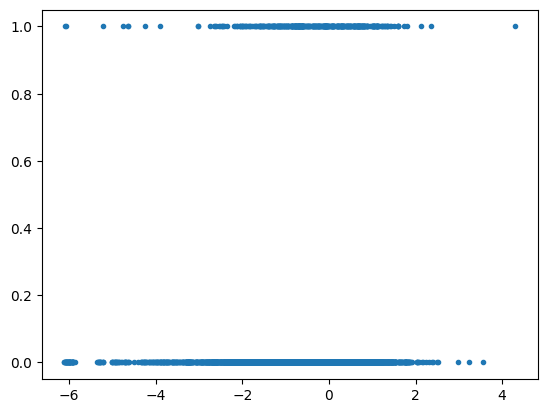

In [61]:
# Explore visually

col = 'consumption_ratio_1'

df_temp = df.sample(100000)

x = df_temp[col].values
x = np.log(x)

y = df_temp['target'].values

plt.plot(x, y, '.');
